In [1]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7298972 bytes but only got 8172. Skipping tag 37724
  " Skipping tag %s" % (size, len(data), tag)


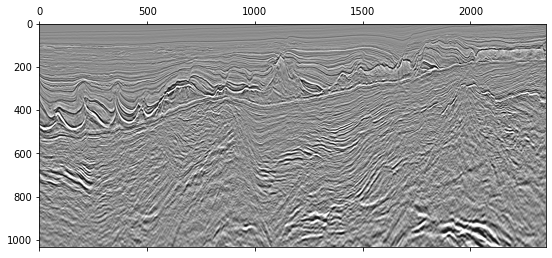

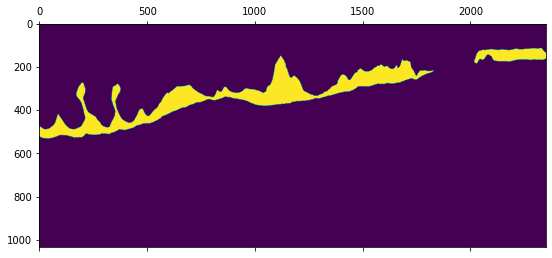

In [5]:
data = mpimg.imread('seismic.tif')
data = data[:,:,:1]/255

mask = mpimg.imread('mask.tif').copy()
mask = (mask-mask.min())/(mask.max()-mask.min())

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

In [6]:
number_train = 5000                             # Number of training examples
number_val   = 1000                             # Number of validation examples
dim          = (64,64,1)                        # Size of examples


def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,2))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding)   
      y[n,0] = mask[t_n,x_n]
      y[n,1] = 1 - mask[t_n,x_n]

  return X, y



X_train, y_train = patchify(data[:,:1200], mask[:,:1200], number_train, dim)
X_val,   y_val   = patchify(data[:,1200:], mask[:,1200:], number_val, dim)

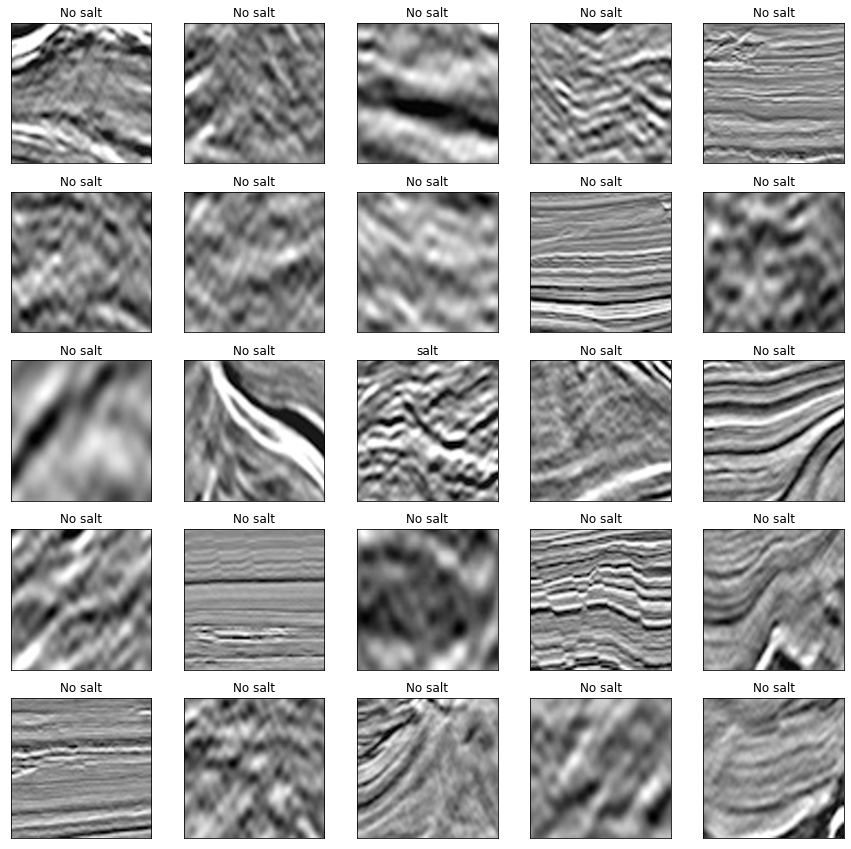

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))

k = 0
for n in range(5):
  for m in range(5):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k,0] == 1:
      axs[n,m].set_title('salt')
    else:
      axs[n,m].set_title('No salt')

In [8]:
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [9]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 14s 8ms/step - loss: 0.2796 - binary_accuracy: 0.9232 - val_loss: 0.2065 - val_binary_accuracy: 0.9670
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2050 - binary_accuracy: 0.9298 - val_loss: 0.2319 - val_binary_accuracy: 0.9340
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1821 - binary_accuracy: 0.9382 - val_loss: 0.1520 - val_binary_accuracy: 0.9550
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1614 - binary_accuracy: 0.9466 - val_loss: 0.1818 - val_binary_accuracy: 0.9440
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1445 - binary_accuracy: 0.9500 - val_loss: 0.2045 - val_binary_accuracy: 0.9270
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.1227 - binary_accuracy: 0.9568 - val_loss: 0.1487 - val_binary_accuracy: 0.9460
Epoch 7/10
157/157 [==============================] - 1s 6ms/st

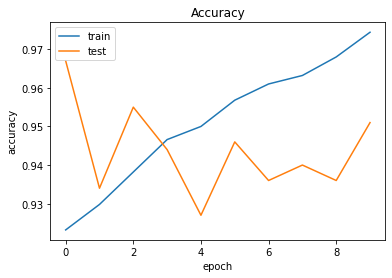

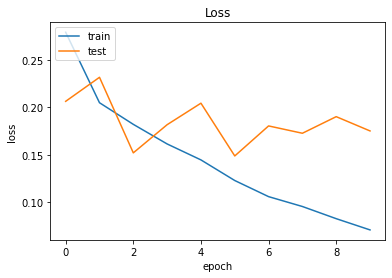

In [10]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

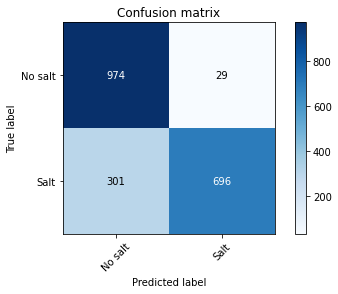

In [11]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va='center',
                    color="white" if cm[i, j] > thresh else "black")



y_true = y_val
y_pred = model.predict(X_val)

cm = confusion_matrix(y_true.astype(int)[:,0], y_pred.astype(int)[:,0]) + np.fliplr(confusion_matrix(y_true.astype(int)[:,1], y_pred.astype(int)[:,1]))
   
plot_confusion_matrix(cm, ['No salt', 'Salt'])

99

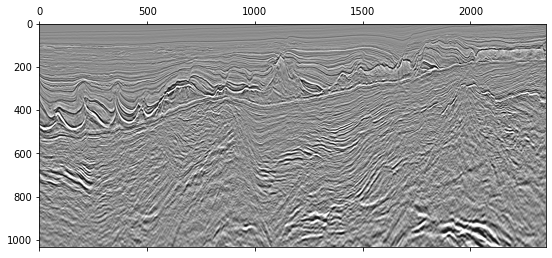

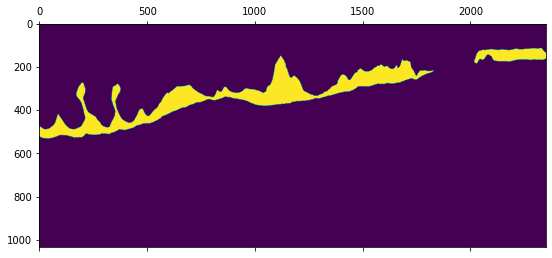

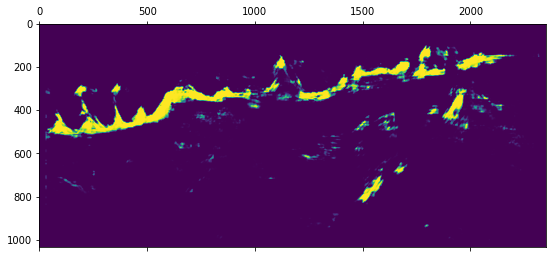

In [12]:
(t_max, x_max, _) = data.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = data[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  result[dim[1]//2:t_max-dim[1]//2,x,:] = model.predict_on_batch(batch)
  n = 0

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()
